# Лабораторная работа № 3
### Провести классификацию найденного датасета, методами линеной и логистической регрессий. В формате Markdown писать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.


## - Импорт библиотек

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

## - Инициализация датасета
#### (Датасет представляет собой данные о прошедших матчах в Бразильском CS:GO)

In [3]:
file_path = r'C:\Users\thebi\tb_lobby_stats_player.csv'

data = pd.read_csv(file_path)

num_rows, num_cols = data.shape
print(f"Количество строк: {num_rows}")
print(f"Количество столбцов: {num_cols}")


Количество строк: 184152
Количество столбцов: 38


In [4]:
print(data.columns)

Index(['idLobbyGame', 'idPlayer', 'idRoom', 'qtKill', 'qtAssist', 'qtDeath',
       'qtHs', 'qtBombeDefuse', 'qtBombePlant', 'qtTk', 'qtTkAssist',
       'qt1Kill', 'qt2Kill', 'qt3Kill', 'qt4Kill', 'qt5Kill', 'qtPlusKill',
       'qtFirstKill', 'vlDamage', 'qtHits', 'qtShots', 'qtLastAlive',
       'qtClutchWon', 'qtRoundsPlayed', 'descMapName', 'vlLevel', 'qtSurvived',
       'qtTrade', 'qtFlashAssist', 'qtHitHeadshot', 'qtHitChest',
       'qtHitStomach', 'qtHitLeftAtm', 'qtHitRightArm', 'qtHitLeftLeg',
       'qtHitRightLeg', 'flWinner', 'dtCreatedAt'],
      dtype='object')


## - Удаление столбцов с необрабатываемыми типами данных или просто не влияющих на исход матча

In [5]:
columns_to_drop = ['idRoom', 'idPlayer', 'idLobbyGame', 'qtFlashAssist', 'qtHitHeadshot', 'qtHitChest',
       'qtHitStomach', 'qtHitLeftAtm', 'qtHitRightArm', 'qtHitLeftLeg',
       'qtHitRightLeg', 'dtCreatedAt', 'descMapName']
data = data.drop(columns=columns_to_drop)

In [6]:
print(data.columns)

Index(['qtKill', 'qtAssist', 'qtDeath', 'qtHs', 'qtBombeDefuse',
       'qtBombePlant', 'qtTk', 'qtTkAssist', 'qt1Kill', 'qt2Kill', 'qt3Kill',
       'qt4Kill', 'qt5Kill', 'qtPlusKill', 'qtFirstKill', 'vlDamage', 'qtHits',
       'qtShots', 'qtLastAlive', 'qtClutchWon', 'qtRoundsPlayed', 'vlLevel',
       'qtSurvived', 'qtTrade', 'flWinner'],
      dtype='object')


## - Поиск пустых значений в датасете и удаление соответствующих строк

In [7]:
# Урезка датасета
data = data.sample(n=50000, random_state=42)

empty_columns = data.columns[data.isnull().any()]
empty_columns_count = data[empty_columns].isnull().sum()

# Вывод столбцов с пустыми значениями и их количество
if len(empty_columns) > 0:
    print("Столбцы с пустыми значениями и их количество:")
    for column in empty_columns:
        print(f"Столбец '{column}': {empty_columns_count[column]} пустых значений")
    print()

    # Удаление строк с пустыми значениями
    data_cleaned = data.dropna()
    print(f"Удалено строк с пустыми значениями: {len(data) - len(data_cleaned)}")
else:
    print("В датасете нет пустых значений")

Столбцы с пустыми значениями и их количество:
Столбец 'qtTk': 37 пустых значений
Столбец 'qtTkAssist': 37 пустых значений
Столбец 'qtHits': 37 пустых значений
Столбец 'qtLastAlive': 37 пустых значений
Столбец 'qtSurvived': 189 пустых значений
Столбец 'qtTrade': 189 пустых значений

Удалено строк с пустыми значениями: 189


## - Поиск столбцов с нечисловыми значениями

In [8]:
non_numeric_columns = data_cleaned.select_dtypes(exclude=['number']).columns.tolist()

if len(non_numeric_columns) > 0:
    print("Столбцы с нечисловыми значениями:")
    for column in non_numeric_columns:
        print(column)
else:
    print("Все столбцы содержат числовые значения")

# Подсчет количества строк и столбцов
num_rows, num_cols = data_cleaned.shape
print(f"Количество строк: {num_rows}")
print(f"Количество столбцов: {num_cols}")

Все столбцы содержат числовые значения
Количество строк: 49811
Количество столбцов: 25


## - Поиск лучшего гиперпараметра fit_intercept для линейной регрессии

In [10]:
%%time
X_train, X_test, y_train, y_test = train_test_split(data_cleaned.drop('flWinner', axis=1), data_cleaned['flWinner'], test_size=0.4, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

under_sampler = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

print(pd.Series(y_resampled).value_counts())
print(y_test.unique())

linear_model = LinearRegression()

linear_params = {'fit_intercept': [True, False]}

linear_grid = GridSearchCV(linear_model, linear_params, cv=5)

linear_grid.fit(X_resampled, y_resampled)

print("Лучшие параметры для линейной регрессии:", linear_grid.best_params_)

0    14731
1    14731
Name: flWinner, dtype: int64
[1 0]
Лучшие параметры для линейной регрессии: {'fit_intercept': True}
Wall time: 233 ms


## - Обучение модели 

MAE:  0.3193257142065935
MSE:  0.14838515908728997
R^2:  0.40637251733015867


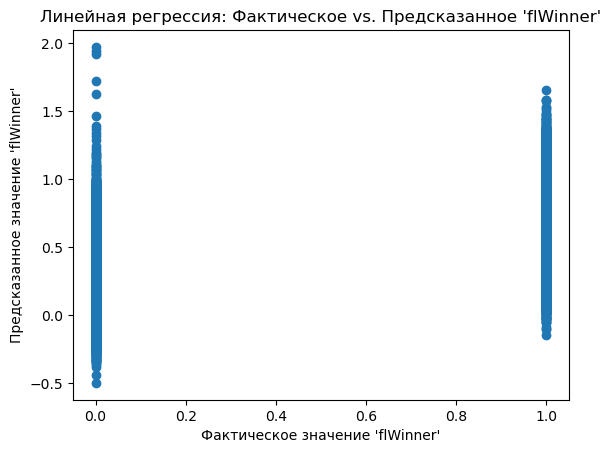

              precision    recall  f1-score   support

           0       0.79      0.81      0.80     10083
           1       0.80      0.78      0.79      9842
           2       0.00      1.00      0.00         0

    accuracy                           0.80     19925
   macro avg       0.53      0.86      0.53     19925
weighted avg       0.80      0.80      0.80     19925

Wall time: 205 ms


In [12]:
%%time

linear_predictions = linear_grid.predict(X_test)

# Оценка качества модели регрессии
mae = mean_absolute_error(y_test, linear_predictions)
mse = mean_squared_error(y_test, linear_predictions)
r2 = r2_score(y_test, linear_predictions)

print("MAE: ", mae)
print("MSE: ", mse)
print("R^2: ", r2)

# Визуализация результатов регрессии
plt.scatter(y_test, linear_predictions)
plt.xlabel("Фактическое значение 'flWinner'")
plt.ylabel("Предсказанное значение 'flWinner'")
plt.title("Линейная регрессия: Фактическое vs. Предсказанное 'flWinner'")
plt.show()

# Вывод отчета классификации
print(classification_report(y_test, rounded_predictions, zero_division=1))

## - Поиск лучших гиперпараметров для логистической регрессии

In [13]:
%%time
X = data_cleaned.drop('flWinner', axis=1)
y = data_cleaned['flWinner']

# Разбиваем данные на обучающую и тестовую выборки (60% - обучающая, 40% - тестовая)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Инициализация модели логистической регрессии с определенными параметрами
logistic_model = LogisticRegression(multi_class='auto', solver='liblinear', max_iter=1000)

# Задаем сетку параметров для подбора лучших гиперпараметров
logistic_params = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}

# Поиск лучших гиперпараметров с помощью перекрестной проверки (cv=5)
logistic_grid = GridSearchCV(logistic_model, logistic_params, cv=5)
logistic_grid.fit(X_train, y_train)
print("Лучшие параметры для логистической регрессии:", logistic_grid.best_params_)

Лучшие параметры для логистической регрессии: {'C': 10, 'penalty': 'l1'}


## - Обучение модели логистической регрессии

Отчет о классификации для логистической регрессии:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80     10083
           1       0.80      0.78      0.79      9842

    accuracy                           0.80     19925
   macro avg       0.80      0.80      0.80     19925
weighted avg       0.80      0.80      0.80     19925



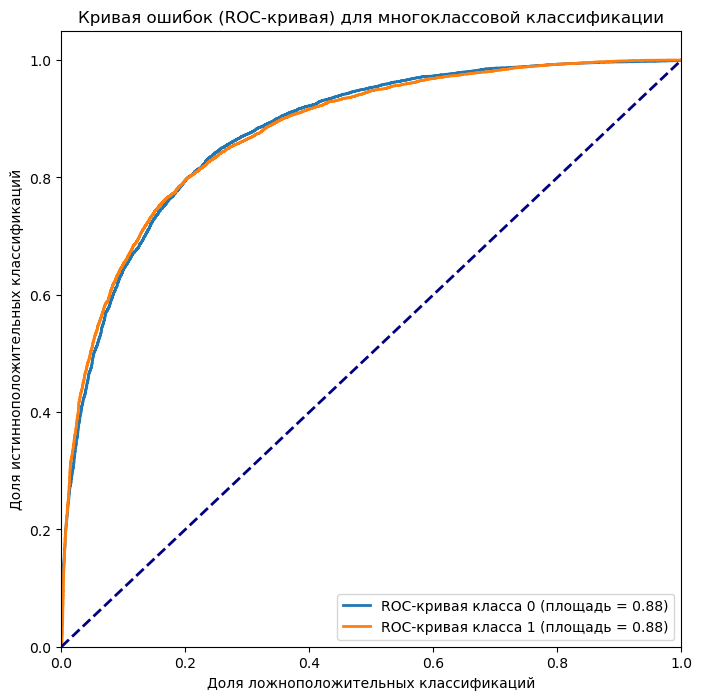

Wall time: 2.17 s


In [20]:
%%time
best_logistic_model = LogisticRegression(
    multi_class='auto',
    solver='liblinear',
    max_iter=1000,
    C=logistic_grid.best_params_['C'],
    penalty=logistic_grid.best_params_['penalty']
)

best_logistic_model.fit(X_train, y_train)

logistic_predictions = best_logistic_model.predict(X_test)
logistic_classification_report = classification_report(y_test, logistic_predictions)
print("Отчет о классификации для логистической регрессии:\n", logistic_classification_report)

logistic_probabilities = best_logistic_model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):  
    fpr[i], tpr[i], _ = roc_curve(y_test == i, logistic_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 8))
for i in range(2):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC-кривая класса {0} (площадь = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Доля ложноположительных классификаций')
plt.ylabel('Доля истинноположительных классификаций')
plt.title('Кривая ошибок (ROC-кривая) для многоклассовой классификации')
plt.legend(loc='lower right')
plt.show()

__На основании проведенной лабораторной работы с использованием логистической регрессии для классификации, мы получили следующие результаты:__

    Лучшие параметры модели: 
    В ходе подбора гиперпараметров логистической регрессии с использованием перекрестной проверки были определены оптимальные значения гиперпараметров: C=10 и penalty='l1'. Эти параметры обеспечивают наилучшую производительность модели для данного набора данных.

    Метрики качества модели:

    Точность (Precision) и Полнота (Recall): Для класса 0 точность составляет 79%, полнота - 81%. Для класса 1 точность равна 80%, полнота - 78%. Это показывает, что модель способна достаточно точно выявлять оба класса, но с небольшой разницей в точности и полноте.

    F1-score: Средневзвешенное значение F1-меры для обоих классов составляет около 0.80. Эта метрика учитывает как точность, так и полноту модели, и показывает их сбалансированность.

    Общая точность модели: Общая точность модели (accuracy) на тестовой выборке составляет 80%. Это означает, что модель правильно классифицировала 80% всех примеров на тестовой выборке.

    Исходя из этих результатов, можно сделать вывод, что модель логистической регрессии с оптимальными гиперпараметрами демонстрирует хорошую способность к классификации обоих классов, однако, возможно, имеет небольшую тенденцию к смещению в сторону класса 0 (имеет немного более высокую полноту, но чуть ниже точность). В целом, данная модель является перспективной для решения задачи классификации на данном наборе данных, но может потребоваться дополнительная настройка или улучшение для улучшения баланса между точностью и полнотой обеих классов. 